# (Split 7/3)

RMSE trên tập test là: 641.006565260871
MAPE trên tập test là: 3.9560693115622727 %
MSLE trên tập test là: 0.0023781986127771678


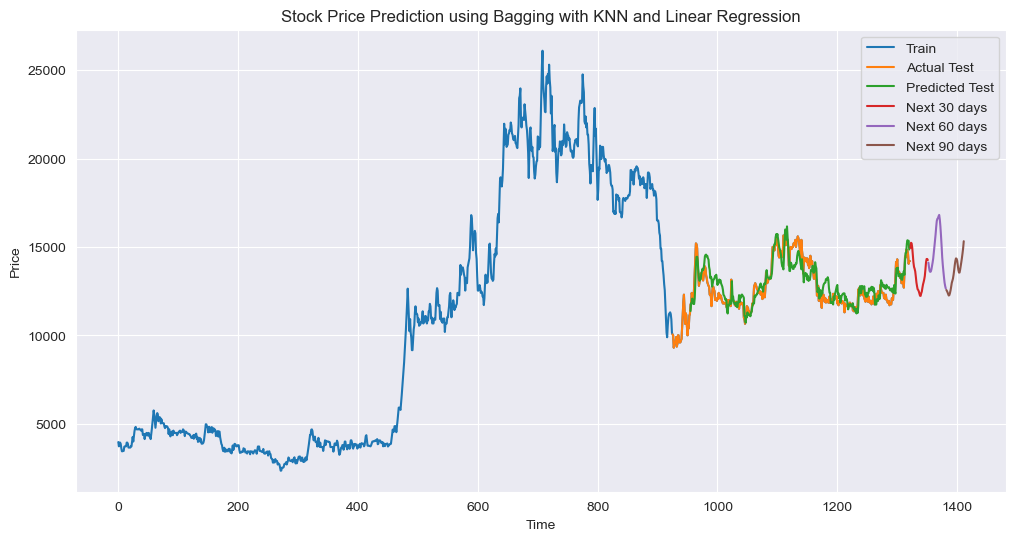

In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_log_error

# Đọc dữ liệu
df = pd.read_csv('D:\\Workspace\\23-24_HK2\\IS403-PTDLKD\\dataset\\SGT.csv', index_col='time', parse_dates=True)
df = df.drop(columns=['open', 'high', 'low', 'volume'])
df = df.reset_index(drop=True)
df.head()

# 2. Đọc file csv và gắn index với Price
df1 = df.reset_index()['close']

# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# 6. Reshape into X=t,t+1,t+2..t+29 and Y=t+30
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Không cần reshape cho các mô hình KNN và Linear Regression
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

# Bước 2: Khởi tạo mô hình con
knn = KNeighborsRegressor(n_neighbors=5)
lr = LinearRegression()

# Bước 3: Bagging với mô hình KNN
bagging_knn = BaggingRegressor(estimator=knn, n_estimators=10, random_state=0)
bagging_knn.fit(X_train, y_train)

# Bagging với mô hình Linear Regression
bagging_lr = BaggingRegressor(estimator=lr, n_estimators=10, random_state=0)
bagging_lr.fit(X_train, y_train)

# Dự đoán với KNN
y_pred_knn = bagging_knn.predict(X_test)
# Dự đoán với Linear Regression
y_pred_lr = bagging_lr.predict(X_test)

# Kết hợp kết quả dự đoán bằng cách lấy trung bình
y_pred = (y_pred_knn + y_pred_lr) / 2

# Đảo ngược quá trình chuẩn hóa dữ liệu
y_pred = y_pred.reshape(-1, 1)
y_pred_new = scaler.inverse_transform(y_pred)
y_test_new = scaler.inverse_transform(y_test.reshape(-1, 1))

# Tính toán RMSE, MAPE và MSLE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

# Dự báo 90 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []

for i in range(90):
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:]).reshape(1, -1)
        x_input = x_input.reshape((1, time_step))
        y_hat_knn = bagging_knn.predict(x_input)
        y_hat_lr = bagging_lr.predict(x_input)
        y_hat = (y_hat_knn + y_hat_lr) / 2
        temp_input.extend(y_hat.tolist())
        temp_input = temp_input[1:]
        lst_output.extend(y_hat.tolist())
    else:
        x_input = x_input.reshape((1, time_step))
        y_hat_knn = bagging_knn.predict(x_input)
        y_hat_lr = bagging_lr.predict(x_input)
        y_hat = (y_hat_knn + y_hat_lr) / 2
        temp_input.extend(y_hat.tolist())
        lst_output.extend(y_hat.tolist())

# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df1), label='Train')
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Actual Test')
test_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + time_step + len(y_pred), step=1)
plt.plot(test_pred_index, y_pred_new, label='Predicted Test')

# Predictions for 30 days
predict_data_index_30 = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(predict_data_index_30, scaler.inverse_transform(np.array(lst_output[:30]).reshape(-1, 1)), label='Next 30 days')

# Predictions for 60 days
predict_data_index_60 = pd.RangeIndex(start=len(df1) + 30, stop=len(df1) + 60, step=1)
plt.plot(predict_data_index_60, scaler.inverse_transform(np.array(lst_output[30:60]).reshape(-1, 1)), label='Next 60 days')

# Predictions for 90 days
predict_data_index_90 = pd.RangeIndex(start=len(df1) + 60, stop=len(df1) + 90, step=1)
plt.plot(predict_data_index_90, scaler.inverse_transform(np.array(lst_output[60:]).reshape(-1, 1)), label='Next 90 days')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction using Bagging with KNN and Linear Regression')
plt.legend()
plt.show()



# (Split 8/2)

RMSE trên tập test là: 545.0351370174459
MAPE trên tập test là: 2.798443816870047 %
MSLE trên tập test là: 0.001554498226104984


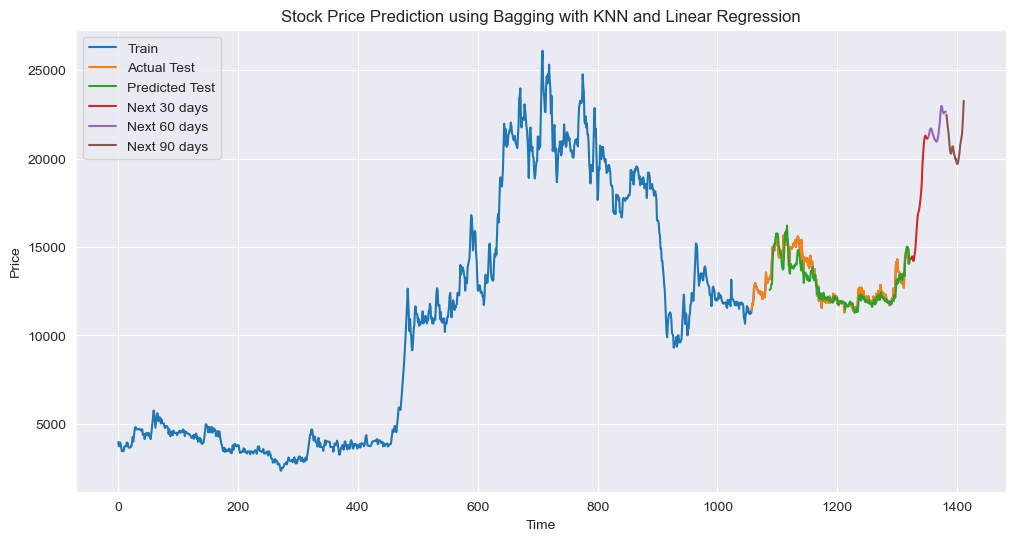

In [2]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_log_error

# Đọc dữ liệu
df = pd.read_csv('D:\\Workspace\\23-24_HK2\\IS403-PTDLKD\\dataset\\SGT.csv', index_col='time', parse_dates=True)
df = df.drop(columns=['open', 'high', 'low', 'volume'])
df = df.reset_index(drop=True)
df.head()

# 2. Đọc file csv và gắn index với Price
df1 = df.reset_index()['close']

# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# 6. Reshape into X=t,t+1,t+2..t+29 and Y=t+30
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Không cần reshape cho các mô hình KNN và Linear Regression
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

# Bước 2: Khởi tạo mô hình con
knn = KNeighborsRegressor(n_neighbors=5)
lr = LinearRegression()

# Bước 3: Bagging với mô hình KNN
bagging_knn = BaggingRegressor(estimator=knn, n_estimators=10, random_state=0)
bagging_knn.fit(X_train, y_train)

# Bagging với mô hình Linear Regression
bagging_lr = BaggingRegressor(estimator=lr, n_estimators=10, random_state=0)
bagging_lr.fit(X_train, y_train)

# Dự đoán với KNN
y_pred_knn = bagging_knn.predict(X_test)
# Dự đoán với Linear Regression
y_pred_lr = bagging_lr.predict(X_test)

# Kết hợp kết quả dự đoán bằng cách lấy trung bình
y_pred = (y_pred_knn + y_pred_lr) / 2

# Đảo ngược quá trình chuẩn hóa dữ liệu
y_pred = y_pred.reshape(-1, 1)
y_pred_new = scaler.inverse_transform(y_pred)
y_test_new = scaler.inverse_transform(y_test.reshape(-1, 1))

# Tính toán RMSE, MAPE và MSLE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

# Dự báo 90 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []

for i in range(90):
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:]).reshape(1, -1)
        x_input = x_input.reshape((1, time_step))
        y_hat_knn = bagging_knn.predict(x_input)
        y_hat_lr = bagging_lr.predict(x_input)
        y_hat = (y_hat_knn + y_hat_lr) / 2
        temp_input.extend(y_hat.tolist())
        temp_input = temp_input[1:]
        lst_output.extend(y_hat.tolist())
    else:
        x_input = x_input.reshape((1, time_step))
        y_hat_knn = bagging_knn.predict(x_input)
        y_hat_lr = bagging_lr.predict(x_input)
        y_hat = (y_hat_knn + y_hat_lr) / 2
        temp_input.extend(y_hat.tolist())
        lst_output.extend(y_hat.tolist())

# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df1), label='Train')
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Actual Test')
test_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + time_step + len(y_pred), step=1)
plt.plot(test_pred_index, y_pred_new, label='Predicted Test')

# Predictions for 30 days
predict_data_index_30 = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(predict_data_index_30, scaler.inverse_transform(np.array(lst_output[:30]).reshape(-1, 1)), label='Next 30 days')

# Predictions for 60 days
predict_data_index_60 = pd.RangeIndex(start=len(df1) + 30, stop=len(df1) + 60, step=1)
plt.plot(predict_data_index_60, scaler.inverse_transform(np.array(lst_output[30:60]).reshape(-1, 1)), label='Next 60 days')

# Predictions for 90 days
predict_data_index_90 = pd.RangeIndex(start=len(df1) + 60, stop=len(df1) + 90, step=1)
plt.plot(predict_data_index_90, scaler.inverse_transform(np.array(lst_output[60:]).reshape(-1, 1)), label='Next 90 days')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction using Bagging with KNN and Linear Regression')
plt.legend()
plt.show()



# (Split 9/1)

RMSE trên tập test là: 354.7309283111004
MAPE trên tập test là: 2.009235880081324 %
MSLE trên tập test là: 0.0007626134399466722


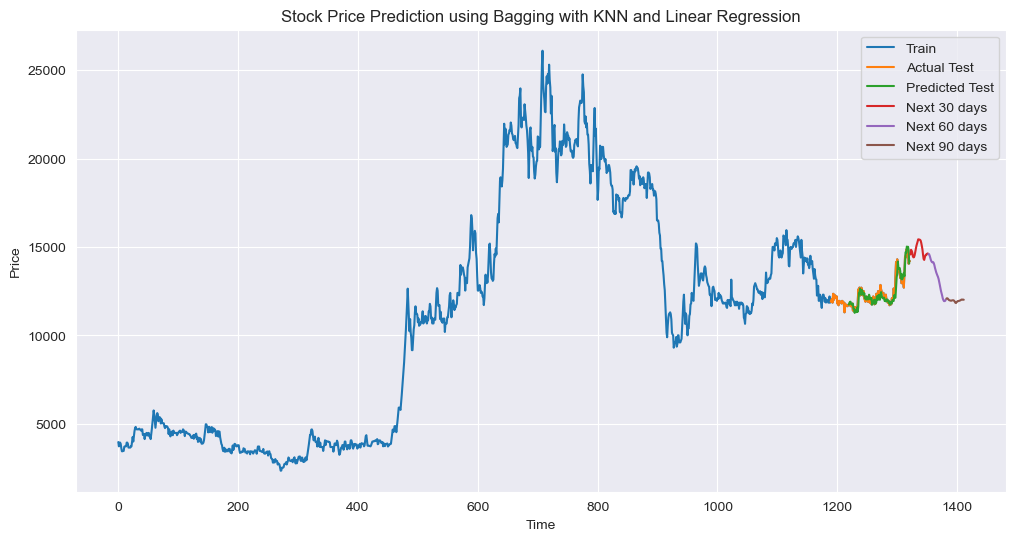

In [3]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_log_error

# Đọc dữ liệu
df = pd.read_csv('D:\\Workspace\\23-24_HK2\\IS403-PTDLKD\\dataset\\SGT.csv', index_col='time', parse_dates=True)
df = df.drop(columns=['open', 'high', 'low', 'volume'])
df = df.reset_index(drop=True)
df.head()

# 2. Đọc file csv và gắn index với Price
df1 = df.reset_index()['close']

# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# 6. Reshape into X=t,t+1,t+2..t+29 and Y=t+30
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Không cần reshape cho các mô hình KNN và Linear Regression
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

# Bước 2: Khởi tạo mô hình con
knn = KNeighborsRegressor(n_neighbors=5)
lr = LinearRegression()

# Bước 3: Bagging với mô hình KNN
bagging_knn = BaggingRegressor(estimator=knn, n_estimators=10, random_state=0)
bagging_knn.fit(X_train, y_train)

# Bagging với mô hình Linear Regression
bagging_lr = BaggingRegressor(estimator=lr, n_estimators=10, random_state=0)
bagging_lr.fit(X_train, y_train)

# Dự đoán với KNN
y_pred_knn = bagging_knn.predict(X_test)
# Dự đoán với Linear Regression
y_pred_lr = bagging_lr.predict(X_test)

# Kết hợp kết quả dự đoán bằng cách lấy trung bình
y_pred = (y_pred_knn + y_pred_lr) / 2

# Đảo ngược quá trình chuẩn hóa dữ liệu
y_pred = y_pred.reshape(-1, 1)
y_pred_new = scaler.inverse_transform(y_pred)
y_test_new = scaler.inverse_transform(y_test.reshape(-1, 1))

# Tính toán RMSE, MAPE và MSLE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

# Dự báo 90 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []

for i in range(90):
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:]).reshape(1, -1)
        x_input = x_input.reshape((1, time_step))
        y_hat_knn = bagging_knn.predict(x_input)
        y_hat_lr = bagging_lr.predict(x_input)
        y_hat = (y_hat_knn + y_hat_lr) / 2
        temp_input.extend(y_hat.tolist())
        temp_input = temp_input[1:]
        lst_output.extend(y_hat.tolist())
    else:
        x_input = x_input.reshape((1, time_step))
        y_hat_knn = bagging_knn.predict(x_input)
        y_hat_lr = bagging_lr.predict(x_input)
        y_hat = (y_hat_knn + y_hat_lr) / 2
        temp_input.extend(y_hat.tolist())
        lst_output.extend(y_hat.tolist())

# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df1), label='Train')
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Actual Test')
test_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + time_step + len(y_pred), step=1)
plt.plot(test_pred_index, y_pred_new, label='Predicted Test')

# Predictions for 30 days
predict_data_index_30 = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(predict_data_index_30, scaler.inverse_transform(np.array(lst_output[:30]).reshape(-1, 1)), label='Next 30 days')

# Predictions for 60 days
predict_data_index_60 = pd.RangeIndex(start=len(df1) + 30, stop=len(df1) + 60, step=1)
plt.plot(predict_data_index_60, scaler.inverse_transform(np.array(lst_output[30:60]).reshape(-1, 1)), label='Next 60 days')

# Predictions for 90 days
predict_data_index_90 = pd.RangeIndex(start=len(df1) + 60, stop=len(df1) + 90, step=1)
plt.plot(predict_data_index_90, scaler.inverse_transform(np.array(lst_output[60:]).reshape(-1, 1)), label='Next 90 days')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction using Bagging with KNN and Linear Regression')
plt.legend()
plt.show()

